# Convolutional Neural Networks (CNN)

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm
from PIL import Image

## Load CIFAR10 dataset for training, testing and validation

In [ ]:
data = torchvision.datasets.CIFAR10('~/data', train=True, download=True)
mu = data.data.mean(axis=(0, 1, 2)) # (N, H, W, 3) -> 3
std = data.data.std(axis=(0, 1, 2)) # (N, H, W, 3) -> 3
print("Dataset size:", data.data.shape, "Mu:", mu, "Sigma:", std)

loader_kwargs = dict(batch_size=128, num_workers=4)

n_valid = 2000

tfms_norm = transforms.Compose([
    transforms.ToTensor(),
    # ToTensor already maps 0-255 to 0-1, so devide mu and std by 255 below
    transforms.Normalize(mu / 255, std / 255),
])


# Now lets keep part of the training data for validation

data_valid = torchvision.datasets.CIFAR10('~/data', train=True, transform=tfms_norm)
data_valid.data = data_valid.data[-n_valid:]
data_valid.targets = data_valid.targets[-n_valid:]
loader_valid = torch.utils.data.DataLoader(data_valid, **loader_kwargs)

# function for loading train data by passing desired transforms for data augmentation
def get_loader_train(augmentations=lambda x: x):
    data_train = torchvision.datasets.CIFAR10(
        '~/data', train=True,
        transform=transforms.Compose([augmentations, tfms_norm])
    )
    data_train.data = data_train.data[:-n_valid]
    data_train.targets = data_train.targets[:-n_valid]
    return torch.utils.data.DataLoader(data_train, **loader_kwargs, shuffle=True)

# test data
data_test = torchvision.datasets.CIFAR10('~/data', train=False, transform=tfms_norm)
loader_test = torch.utils.data.DataLoader(data_test, **loader_kwargs)

100%|██████████| 170498071/170498071 [00:12<00:00, 13693464.80it/s]


Extracting /root/data/cifar-10-python.tar.gz to /root/data
Dataset size: (50000, 32, 32, 3) Mu: [125.30691805 122.95039414 113.86538318] Sigma: [62.99321928 62.08870764 66.70489964]


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Complete the following function to build your CNN layer

In [ ]:
# Tip: dont forget to include activation layer (ReLu)

def build_cnn_layer(in_channels, out_channels, kernel_size=3, stride=1, padding=1,
                    use_batchnorm=True, pool=False):
    '''
    in_channels: input channels to 2d convolution layer
    out_channels: ouput channels to 2d convolution layer
    kernel_size: kernel size (refer torch conv2d)
    stride: stride (refer torch conv2d)
    padding: padding (refer torch conv2d)
    use_batchnorm: enable/disable batchnorm (refer torch BatchNorm2d)
    pool: enable/disable pooling (refer torch MaxPool2D)

    should return the built CNN layer
    '''
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity(),
        nn.MaxPool2d(2, 2) if pool else nn.Identity(),
    )



## Complete the following function to build CNN model

In [ ]:
# Tip: 4 CNN layers should be sufficient!, increase the no. of channels from 3 -> 32 -> 64 -> 512,
# Remember to flatten after convolution layers before its passed to linear layers
# Also activation layer for final layers

def build_cnn_model(pool=False):
    '''
    pool: enable/disable pooling

    should return built CNN model
    '''
    nf = 32
    s = 1 if pool else 2
    return nn.Sequential(
        # (B, 3, 32, 32) images
        build_cnn_layer(3, nf),  # (B, nf, 32, 32)
        build_cnn_layer(nf, 2 * nf, stride=s, pool=pool),  # (B, 2 * nf, 16, 16)
        build_cnn_layer(2 * nf, 4 * nf, stride=s, pool=pool),  # (B, 4 * nf, 8, 8)
        build_cnn_layer(4 * nf, 8 * nf, stride=s, pool=pool),  # (B, 8 * nf, 4, 4)
        nn.Flatten(), # (B, 8 * nf * 4 * 4)
        nn.Linear(8 * nf * 4 * 4, 512), nn.ReLU(True), nn.BatchNorm1d(512), # (B, 512)
        nn.Linear(512, 10), # (B, 10) logits
    )

## You can use the following helper functions for training the model

In [ ]:
def one_epoch(model, data_loader, opt=None):
    device = next(model.parameters()).device
    train = False if opt is None else True
    model.train() if train else model.eval()
    losses, correct, total = [], 0, 0
    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        with torch.set_grad_enabled(train):
            logits = model(x)
        loss = F.cross_entropy(logits, y)

        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()

        losses.append(loss.item())
        total += len(x)
        correct += (torch.argmax(logits, dim=1) == y).sum().item()
    return np.mean(losses), correct / total


def train(model, loader_train, loader_valid, lr=1e-3, max_epochs=30, weight_decay=0., patience=3):
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_valid_accuracy = 0
    best_valid_accuracy_epoch = 0

    t = tqdm(range(max_epochs))
    for epoch in t:
        train_loss, train_acc = one_epoch(model, loader_train, opt)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        valid_loss, valid_acc = one_epoch(model, loader_valid)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        t.set_description(f'train_acc: {train_acc:.2f}, valid_acc: {valid_acc:.2f}')

        if valid_acc > best_valid_accuracy:
            best_valid_accuracy = valid_acc
            best_valid_accuracy_epoch = epoch

        if epoch > best_valid_accuracy_epoch + patience:
            break
    t.set_description(f'best valid acc: {best_valid_accuracy:.2f}')

    return train_losses, train_accuracies, valid_losses, valid_accuracies


def plot_history(train_losses, train_accuracies, valid_losses, valid_accuracies):
    plt.figure(figsize=(7, 3))

    plt.subplot(1, 2, 1)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    p = plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.ylim(0, 2)
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    p = plt.plot(train_accuracies, label='train')
    plt.plot(valid_accuracies, label='valid')
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

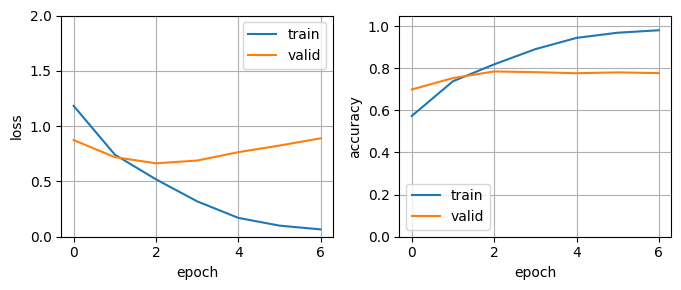

In [ ]:
# stride, no augmentation
model = build_cnn_model().cuda()
loader_train = get_loader_train()
plot_history(*train(model, loader_train, loader_valid))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/30 [00:00<?, ?it/s]

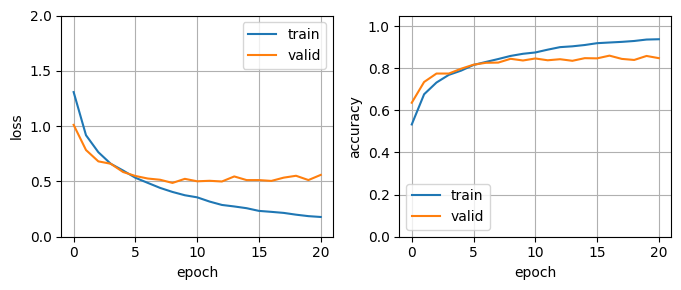

In [ ]:
affine_hflip = transforms.Compose([
    transforms.RandomAffine(
        degrees=10, translate=(.05, .05),
        shear=(-5, 5), interpolation=transforms.InterpolationMode.BILINEAR,
        fill=tuple(np.around(mu).astype(int)),
    ),
    transforms.RandomHorizontalFlip(),
])

# stride, affine_hflip
model = build_cnn_model().cuda()
loader_train = get_loader_train(affine_hflip)
plot_history(*train(model, loader_train, loader_valid))

  0%|          | 0/30 [00:00<?, ?it/s]

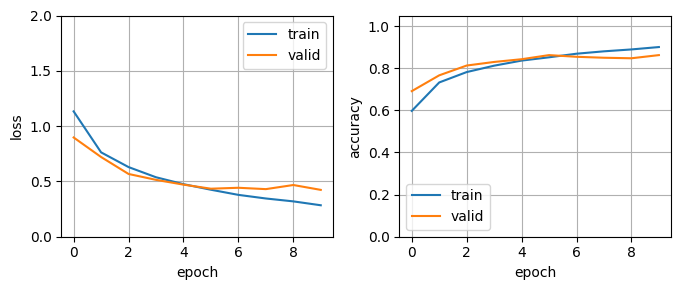

In [ ]:
# max pool, affine_hflip
model = build_cnn_model(pool=True).cuda()
loader_train = get_loader_train(affine_hflip)
plot_history(*train(model, loader_train, loader_valid))

In [ ]:
test_acc = one_epoch(model, loader_test)[1]
print(f'{test_acc * 100:.1f} % test accuracy')

84.7 % test accuracy


# Bonus:  
loading a resnet18 pretrained on Imagenet (classification of 1k classes on ~1M images) and finetuning on cifar10.

Taking a model trained on one task and  images has learnt a representation which we hope will help in classifying CIFAR10 images. (We hope that the model transfers to our problem). Transfer learning.

In [ ]:
model = torchvision.models.resnet18(pretrained=True)
print(model)
# See that the head after the conv-layers (in the bottom) is one linear layer, from 512 features to 1k-class logits.
# We want to replace it with a new head to 10-class logits:
model.fc = nn.Linear(512, 10)
# Also, the model has been trained on images with a resolution of 224. Let's upscale our cifar10 images:
model = nn.Sequential(
    nn.UpsamplingBilinear2d((224, 224)),
    model,
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

  0%|          | 0/30 [00:00<?, ?it/s]

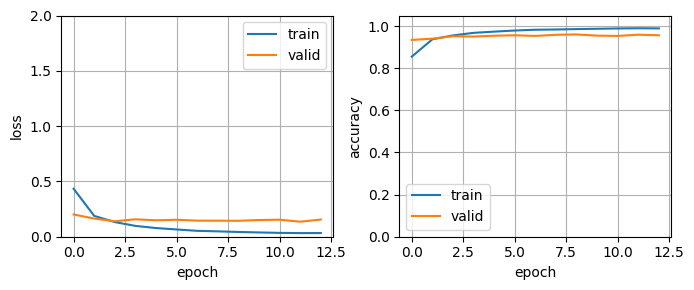

In [ ]:
model = model.cuda()
loader_train = get_loader_train(affine_hflip)
plot_history(*train(model, loader_train, loader_valid, lr=1e-4))

In [ ]:
test_acc = one_epoch(model, loader_test)[1]
print(f'{test_acc * 100:.1f} % test accuracy')

95.1 % test accuracy


For comparison, [this guy](http://karpathy.github.io/2011/04/27/manually-classifying-cifar10/) got 94 % accuracy by manually labeling the test set (estimated human performance),  
and the winner of the [CIFAR10 Kaggle competition](https://www.kaggle.com/c/cifar-10/leaderboard) in 2015 achieved 95.5 % accuracy.  
![mindblown](https://media.giphy.com/media/Um3ljJl8jrnHy/giphy.gif)

([current state of the art](https://paperswithcode.com/sota/image-classification-on-cifar-10) achieves > 99 % though)